In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt    
from matplotlib.patches import Rectangle
from astropy.wcs import WCS                 
from astropy import units as u  
import pylab
import numpy as np
from spectral_cube import SpectralCube     
import pyspeckit
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


# Finds center of cloud c

In [2]:
path="B.Dust_Ridge_sci.spw25_27_29_31.cont.I.tt0.pbcor.fits"
header=fits.getheader(path)
w1=WCS(header)
w1 = w1.dropaxis(3)
w1 = w1.dropaxis(2)

#finds the pixel positions for the RA and dec
#find RA DEC of x,y,z
core_coords=w1.pixel_to_world(175,166)
print(core_coords)

<SkyCoord (ICRS): (ra, dec) in deg
    (266.58818356, -28.59536026)>


# Plots Spectrum

(array(144.), array(136.5882353))
Noise lower: 110.10278837488339 GHz
Noise upper: 110.1088925428445 GHz
Width: 0.006104167961112239 GHz
sigma: 0.0607689173106838 K
3 sigma: 0.1823067519320514 K


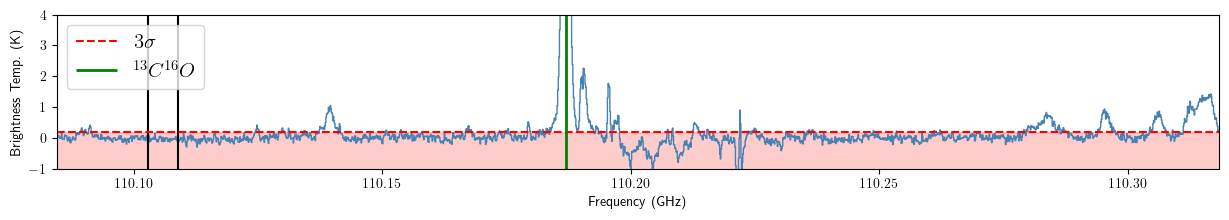

In [7]:

#reads in file
path="A.Dust_Ridge_13C16O.cube.I.pbcor.fits"
#makes figure
fig1=pylab.figure(1,figsize=(15,2))



#find the corresponding pixel positions for those coords in new image
header=fits.getheader(path)
w2=WCS(header)
image_coords=core_coords.to_pixel(w2,0,mode="wcs")
print(image_coords)

#plots spectrum
sc=SpectralCube.read(path)
sc.allow_huge_operations=True 
sc_Ghz=sc.with_spectral_unit(u.GHz)
sc_Ghz=sc_Ghz.to(u.K)
freq,Dec,Ra = sc_Ghz.world[:,0,0] 
subcube=sc_Ghz.hdu.data[:,int(image_coords[0])-5:int(image_coords[0])+5,int(image_coords[1])-5:int(image_coords[1])+5]
spectrum = np.average(subcube,axis=(1,2)) 
ax1=pylab.subplot()
ax1.plot(freq,spectrum,lw=1,drawstyle='steps-mid',color="SteelBlue")
pylab.xlabel("Frequency (GHz)", fontsize=10)
    
pylab.ylabel('Brightness Temp. (K)',fontsize=10)
pylab.ylim(-1,4)

plt.rcParams['text.usetex'] = True

###Noise###
Noise_upper=200
Noise_lower=150
width=freq[Noise_upper]-freq[Noise_lower]
print(f"Noise lower: {freq[Noise_lower]}")
print(f"Noise upper: {freq[Noise_upper]}")
print(f"Width: {width}")
#lower line
pylab.vlines(freq[Noise_lower].value,-1,4,colors="black")
#upper line
pylab.vlines(freq[Noise_upper].value,-1,4,colors="black")
#calculate 3 sigma
sigma=np.std(spectrum[Noise_lower:Noise_upper])
three_sigma=3*sigma
#three_sigma_Jy=three_sigma.to(u.jansky)
print(f"sigma: {sigma} K")
print(f"3 sigma: {three_sigma} K")
#print(f"3 sigma: {three_sigma_Jy} Jy")
pylab.hlines(three_sigma,freq[0].value,freq[1915].value,colors="red",label =r'$3 \sigma$',ls="--" )
pylab.xlim(freq[0].value,freq[1916].value)
ax1.fill_between(freq.value,three_sigma, -2, alpha = 0.2, color= 'red' )

pylab.vlines(110.187,-2,7,colors="green",label=r"${}^{13}C^{16}O$",lw=2)

plt.legend(loc="upper left", fontsize=15)
#plt.title()
plt.savefig("13C16O.pdf")


# Sigma Noise

In [10]:
sigma_pop=np.std(spectrum[0:400])
sigma_sample=np.std(spectrum[0:400], ddof=1)
print(sigma_sample)
print(sigma_pop)
print(freq[0],freq[400])

0.11034682036523911
0.11020880052339992
110.08447587100002 GHz 110.13330921468899 GHz


# CO line ID

819


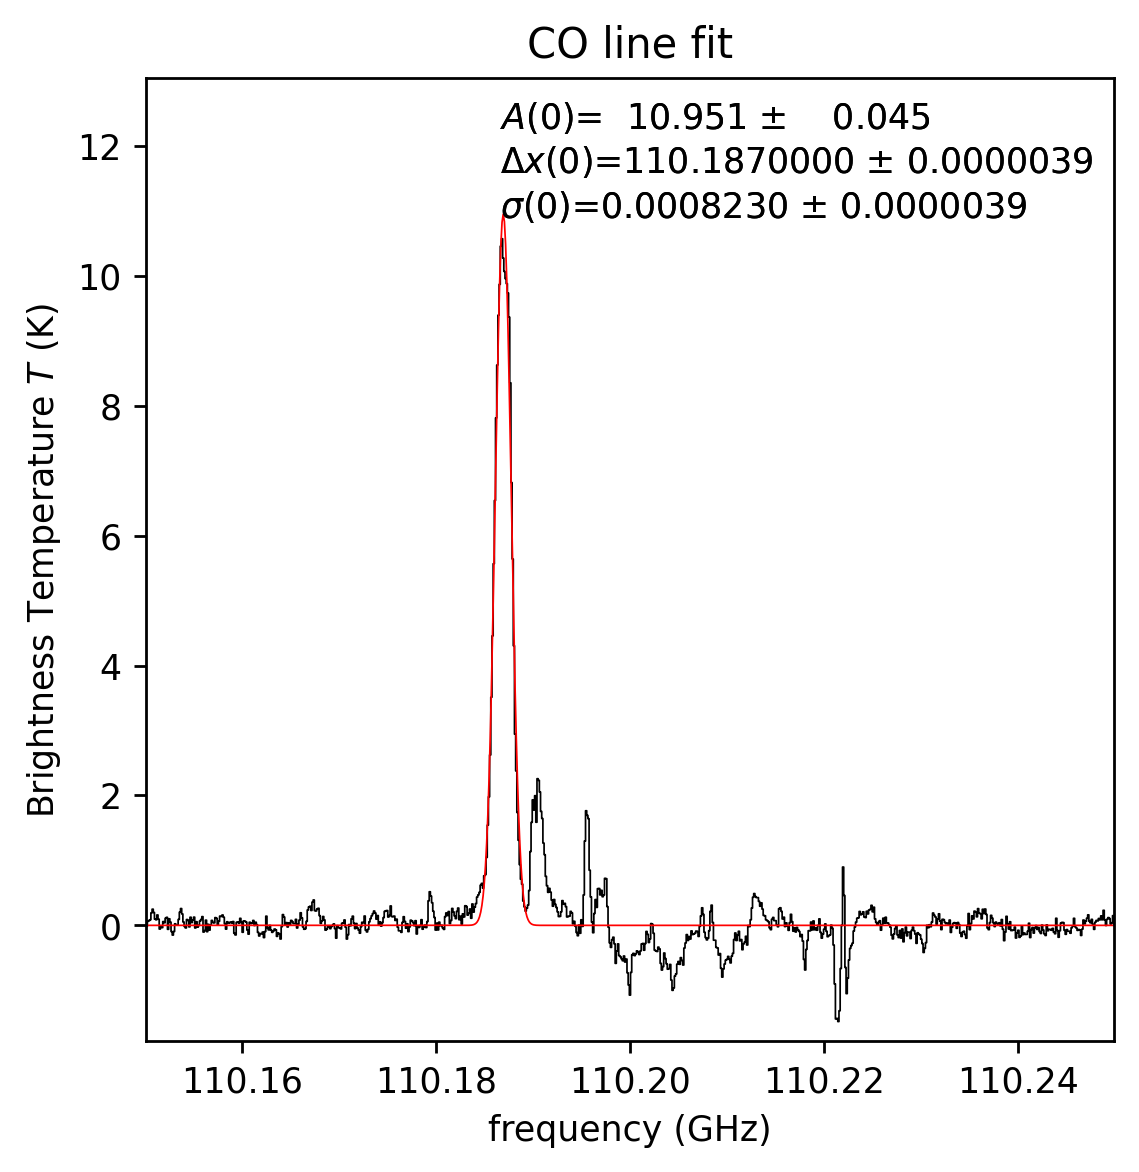

In [13]:
#zooms in on major intensity spike (assumed to be 12CO)
zoom = np.where((freq.value>110.15)*(freq.value<110.25))

#zooms in on the spectrum we found in the last code block
zoom_13C160=spectrum[zoom]
print(len(zoom_13C160))

#zooms in on the frequency's in this zoomed in region
zoom_freq = freq[zoom]


error = np.zeros(np.size(zoom))
wheremeas = np.where((zoom_freq.value>110.16)*(zoom_freq.value<110.17))
meas = np.std(zoom_13C160[wheremeas])  
error = error + meas

#print((zoom_13C160))
sp = pyspeckit.Spectrum(data=zoom_13C160,xarr=zoom_freq,error=error,unit="K")
fig1 = pylab.figure(1,figsize=(5,5),dpi=250)
sp.plotter(axis=pylab.subplot(1,1,1), title="CO line fit")
sp.specfit(fittype='gaussian')
sp.plotter.savefig('COline_13C16O.png')
#print(sp.specfit.parinfo)